<a href="https://colab.research.google.com/github/meowster99/news-sentiment-analysis/blob/main/BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install tensorflow
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 32.6 MB/s 
     |████████████████████████████████| 163 kB 69.8 MB/s 
     |████████████████████████████████| 7.6 MB 53.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 31.4 MB/s 


In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertConfig, TFBertModel, BertTokenizer, TFBertForSequenceClassification, TFDistilBertModel, TFAutoModelForSequenceClassification

import time
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import pad_sequences


SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!cat /proc/meminfo

MemTotal:       13297220 kB
MemFree:         7888636 kB
MemAvailable:   10270456 kB
Buffers:           68032 kB
Cached:          2156324 kB
SwapCached:            0 kB
Active:           486532 kB
Inactive:        4529808 kB
Active(anon):      15936 kB
Inactive(anon):  2420556 kB
Active(file):     470596 kB
Inactive(file):  2109252 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1156 kB
Writeback:             0 kB
AnonPages:       2792000 kB
Mapped:           727848 kB
Shmem:             11548 kB
KReclaimable:      87100 kB
Slab:             133016 kB
SReclaimable:      87100 kB
SUnreclaim:        45916 kB
KernelStack:        4960 kB
PageTables:        60448 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648608 kB
Committed_AS:    4064876 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       53500 kB
VmallocChunk:          0 kB
Percpu:          

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
class time_for_epoch(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


# BERT For Dataset A: Financial News Dataset

## Loading News Data

In [10]:
# Read Train and Test data
#import the train and test files for financial news
fnews_Xtrain = pd.read_csv('fnews_Xtrain.csv')
fnews_Xtest = pd.read_csv('fnews_Xtest.csv')
fnews_ytrain = pd.read_csv('fnews_ytrain.csv')
fnews_ytest = pd.read_csv('fnews_ytest.csv')

# drop the first column for all the train and test sets
fnews_Xtrain.drop(columns=fnews_Xtrain.columns[0], axis=1, inplace=True)
fnews_ytrain.drop(columns=fnews_ytrain.columns[0], axis=1, inplace=True)
fnews_Xtest.drop(columns=fnews_Xtest.columns[0], axis=1, inplace=True)
fnews_ytest.drop(columns=fnews_ytest.columns[0], axis=1, inplace=True)

#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain.shape, 'ytrain:' ,fnews_ytrain.shape)
print('Xtest:',fnews_Xtest.shape, 'ytest:' ,fnews_ytest.shape)

Xtrain: (3876, 1) ytrain: (3876, 1)
Xtest: (970, 1) ytest: (970, 1)


In [ ]:
fnews_Xtrain.head()

,News
0,"['russia', 'raisio', 's', 'food', 'division', ..."
1,"['operator', 'need', 'learn', 'use', 'device',..."
2,"['company', 'expects', 'net', 'sale', 'half', ..."
3,"['bridge', 'km', 'long', 'located', 'anasmotet..."
4,"['nokia', 'capcom', 'announced', 'resident', '..."


## Preparing Data for BERT

In [11]:
# set the maximum length of sentences for BERT
MAX_LEN = max([len(x) for x in fnews_Xtrain["News"]])

# some dataset handling
fnews_Xtrain['News'] = fnews_Xtrain['News'].apply(eval)
fnews_Xtest['News'] = fnews_Xtest['News'].apply(eval)

# preparing the data for BERT
def create_attention_masks(df):
    # BERT requires special tokens at the beginning and end of each sentence for it to work properly
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    input_ids = []
    token_type_ids = []
    attention_masks = []
    for headline in df:
        tokenized_texts = tokenizer.encode_plus(" ".join(headline),
                                                    add_special_tokens=True,
                                                    max_length=MAX_LEN,
                                                    padding='max_length',
                                                    truncation=True,
                                                    return_attention_mask=True)
        input_ids.append(tokenized_texts['input_ids'])
        token_type_ids.append(tokenized_texts['token_type_ids'])
        attention_masks.append(tokenized_texts['attention_mask'])
    return input_ids, token_type_ids, attention_masks

# mapping the classes to a numeric representation
train_labels = fnews_ytrain['Class'].map({'neutral':1, 'positive': 2, 'negative': 0}).values
test_labels = fnews_ytest['Class'].map({'neutral':1, 'positive': 2, 'negative': 0}).values

# split into train, val and test datasets and check the shapes
train_input_ids, train_tokens, train_attention_masks = create_attention_masks(fnews_Xtrain['News'])
test_input_ids, test_tokens, test_attention_masks = create_attention_masks(fnews_Xtest['News'])
ttrain_input_ids, val_input_ids, ttrain_tokens, val_tokens, ttrain_attention_masks, val_attention_masks, ttrain_labels, val_labels  = train_test_split(train_input_ids, train_tokens, train_attention_masks, train_labels, test_size=0.2)
print('Train shape: ', len(ttrain_input_ids), len(ttrain_tokens), len(ttrain_attention_masks), len(ttrain_labels))
print('Val shape: ', len(val_input_ids), len(val_tokens), len(val_attention_masks), len(val_labels))
print('Test shape: ', len(test_input_ids), len(test_tokens), len(test_attention_masks), len(test_labels))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Train shape:  3100 3100 3100 3100
Val shape:  776 776 776 776
Test shape:  970 970 970 970


In [12]:
NUM_CLASSES = 3
ttrain_inputs = tf.convert_to_tensor(ttrain_input_ids, dtype=tf.int32, name='input_ids')
val_inputs = tf.convert_to_tensor(val_input_ids, dtype=tf.int32, name='input_ids')
test_inputs = tf.convert_to_tensor(test_input_ids, dtype=tf.int32, name='input_ids')

ttrain_tokens = tf.convert_to_tensor(ttrain_tokens,dtype=tf.int32, name='token_ids')
val_tokens = tf.convert_to_tensor(val_tokens, dtype=tf.int32, name='token_ids')
test_tokens = tf.convert_to_tensor( test_tokens, dtype=tf.int32, name='token_ids')

ttrain_masks = tf.convert_to_tensor(ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
val_masks = tf.convert_to_tensor(val_attention_masks, dtype=tf.int32, name='attention_masks')
test_masks = tf.convert_to_tensor(test_attention_masks, dtype=tf.int32, name='attention_masks')

# ttrain_labels = tf.convert_to_tensor(ttrain_labels)
# val_labels = tf.convert_to_tensor(val_labels)
# test_labels = tf.convert_to_tensor(test_labels)

ttrain_labels = tf.keras.utils.to_categorical(ttrain_labels, num_classes=NUM_CLASSES)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=NUM_CLASSES)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)


def map_to_dict(inputs, masks, tokens, labels):
    return {
        'input_ids': inputs,
        'attention_masks': masks,
        'token_ids': tokens,
    }, labels

BATCH_SIZE = 8 # larger batch sizes would crash our kernel
train_ds = tf.data.Dataset.from_tensor_slices((ttrain_inputs, ttrain_masks, ttrain_tokens, ttrain_labels)).map(map_to_dict).shuffle(len(ttrain_inputs)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_masks, val_tokens, val_labels)).map(map_to_dict).shuffle(len(val_inputs)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_inputs, test_masks, test_tokens, test_labels)).map(map_to_dict).shuffle(len(test_inputs)).batch(BATCH_SIZE)

In [ ]:
## Initialize pre-built BERT-based classifier from transformers
def create_base_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    # tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 
    inputs = [ids, masks]
    config = BertConfig()
    config.output_hidden_states = False
    bert_model = TFAutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    # outputs = bert_model(input_ids=ids, attention_mask=masks, token_type_ids=tokens)
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model
epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
bert_model = create_base_model()
# bert_model = TFBertForSequenceClassification.from_pretrained(
#         'bert-base-uncased', num_labels=NUM_CLASSES)
bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['vocab_layer_norm', 'distilbert', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_masks[0][0]']        
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [13]:
from datetime import datetime
from tensorflow.keras.callbacks import Callback
log_dir = "bert-distilled/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

te = time_for_epoch()     

In [ ]:
base_model_history = bert_model.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te, es]
                         )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['distilbert', 'vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_1 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]']        
 sification)                    logits=(None, 2),                                                 
                                 hidden_states=None                                         

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


388/388 [==============================] - 298s 724ms/step - loss: 0.9137 - accuracy: 0.6065 - precision: 0.6245 - recall: 0.5155 - val_loss: 0.8569 - val_accuracy: 0.6366 - val_precision: 0.6571 - val_recall: 0.6224
Epoch 2/10
388/388 [==============================] - 273s 704ms/step - loss: 0.8366 - accuracy: 0.6397 - precision: 0.6757 - recall: 0.5645 - val_loss: 0.8186 - val_accuracy: 0.6482 - val_precision: 0.6759 - val_recall: 0.5966
Epoch 3/10
388/388 [==============================] - 273s 703ms/step - loss: 0.7234 - accuracy: 0.6842 - precision: 0.7347 - recall: 0.6200 - val_loss: 0.7745 - val_accuracy: 0.6546 - val_precision: 0.7099 - val_recall: 0.5644
Epoch 4/10
388/388 [==============================] - 274s 707ms/step - loss: 0.6068 - accuracy: 0.7374 - precision: 0.7737 - recall: 0.6884 - val_loss: 0.8553 - val_accuracy: 0.6082 - val_precision: 0.6377 - val_recall: 0.5760
Epoch 5/10
388/388 [==============================] - 279s 719ms/step - loss: 0.5215 - accuracy: 0.

In [14]:
def f1_score(precision, recall):
   return 2*((precision*recall)/(precision+recall))

print('Train F1 Score of last epoch: ', f1_score(0.8349,0.7845))
print('Val F1 Score of last epoch: ', f1_score(0.6134,0.6031))

Train F1 Score of last epoch:  0.8089157095220453
Val F1 Score of last epoch:  0.6082063953966297


In [15]:
def plot_acc_loss_against_epoch(model, max_range, title1='', title2=''):
  plt.figure()
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Model Accuracy (Training)') if title1=='' else plt.title(title1)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper left')

  plt.figure()
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model Loss (Training)') if title2=='' else plt.title(title2)
  plt.ylabel('cross-entropy')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper right')
  
def plot_prec_recall_against_epoch(model, max_range, title1='', title2=''):
  plt.figure()
  plt.plot(model.history['precision'])
  plt.plot(model.history['val_precision'])
  plt.title('Model Precision (Training)') if title1=='' else plt.title(title1)
  plt.ylabel('precision')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper left')

  plt.figure()
  plt.plot(model.history['recall'])
  plt.plot(model.history['val_recall'])
  plt.title('Model Recall (Training)')  if title2=='' else plt.title(title2)
  plt.ylabel('Recall')
  plt.xlabel('epoch')
  plt.xticks(range(0,max_range))
  plt.legend(['train', 'val'], loc='upper right')

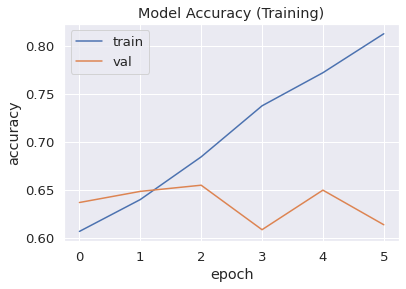

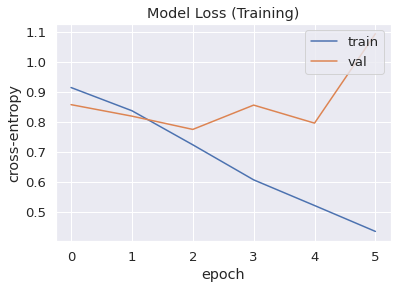

In [ ]:
plot_acc_loss_against_epoch(base_model_history, 6)

Model has a tendency to overfit and not reach convergence.

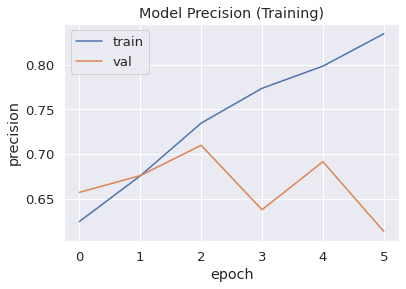

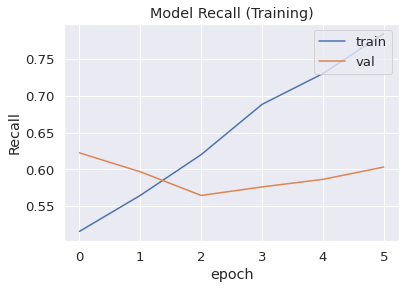

In [ ]:
plot_prec_recall_against_epoch(base_model_history, 6)

In [ ]:
print('Time for each epoch: ', sum(te.times)/len(te.times))

Time for each epoch:  277.876158952713


In [ ]:
bert_model.evaluate(test_ds)

122/122 [==============================] - 27s 218ms/step - loss: 0.7400 - accuracy: 0.6804 - precision: 0.7285 - recall: 0.6031


[0.7399803996086121,
 0.6804123520851135,
 0.7285180687904358,
 0.6030927896499634]

In [ ]:
print('Test F1 Score: ', f1_score(0.7285,0.6031))

Test F1 Score:  0.6598953890057074


In [16]:
def print_all_results(model, model_history, te, predict=True):
  last_idx = len(model_history.history['precision'])-1
  print('Train F1 Score of last epoch: ', f1_score(model_history.history['precision'][last_idx],model_history.history['recall'][last_idx]))
  print('Val F1 Score of last epoch: ', f1_score(model_history.history['val_precision'][last_idx],model_history.history['val_recall'][last_idx]))
  print('Time for each epoch: ', sum(te.times)/len(te.times))
  if predict:
    preds = model.evaluate(test_ds)
    print('Test Prediction Results: ', preds)
    print('Test F1 Score: ', f1_score(preds[2],preds[3]))

## Using Base Bert Models - 'bert-base' and 'distilbert-base'

In [ ]:
## Initialize pre-built BERT-based classifier from transformers
def create_full_base_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False
    # We are NOT using the Distilled Version in this case
    # We will also using the token_type_ids as inputs for this BERT Model
    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
bert_model_full = create_full_base_model()
bert_model_full.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_1 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

In [ ]:
log_dir = "bert-full/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class time_for_epoch(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

te_full = time_for_epoch()      
bert_model_full_history = bert_model_full.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te_full, es]
                         )

In [ ]:
print('Train F1 Score of last epoch: ', f1_score(0.9601,0.9558))
print('Val F1 Score of last epoch: ', f1_score(0.8305,0.8209))

Train F1 Score of last epoch:  0.9579451745915757
Val F1 Score of last epoch:  0.825672096403052


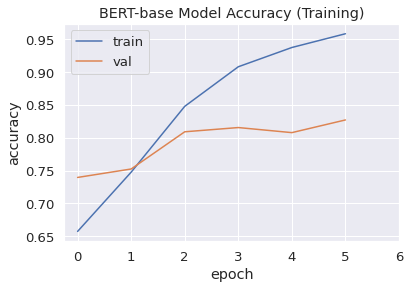

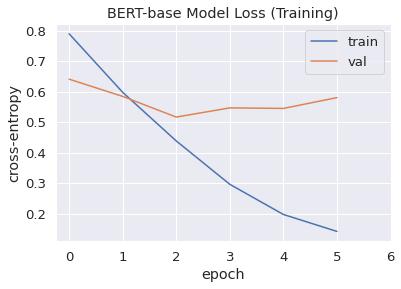

In [ ]:
plot_acc_loss_against_epoch(bert_model_full_history, 6,  title1='BERT-base Model Accuracy (Training)', title2='BERT-base Model Loss (Training)')

In [ ]:
plot_prec_recall_against_epoch(bert_model_full_history, 6, title1='BERT-base Model Precision (Training)', title2='BERT-base Model Recall (Training)')

In [ ]:
print('Time for each epoch: ', sum(te_full.times)/len(te_full.times))

In [ ]:
bert_model_full.evaluate(test_ds)

122/122 [==============================] - 27s 219ms/step - loss: 0.5829 - accuracy: 0.8093 - precision: 0.8245 - recall: 0.7701


[0.5829474329948425,
 0.8092783689498901,
 0.8245033025741577,
 0.7701030969619751]

In [ ]:
print('Test F1 Score: ', f1_score(0.8245,0.7701))

Test F1 Score:  0.7963720682302772


Bert-base appears to work better than DistilledBERT. 

## Modifying BERT-base to prevent overfitting & to improve performance

We will do the following to improve the performance of BERT. 

First, add a dropout layer to prevent overfitting.

Second, test different MAX_LEN on the dataset to see if truncating the sentences earlier improves the model performance.

Third, apply hyperparameter tuning for the learning_rate, and batch_size (unable to do batch_size due to computational limitations).

Fourth, use backtranslation to upsample the dataset due to the uneven class distribution (unable to do backtranslation due to computational limitations). 
OR Apply data augmentation to the upsampled classes.

### Adding a dropout layer

In [ ]:
def create_modified_model():
    """ Adding a dropout layer to prevent overfitting. """
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dropout(0.2)(embedded_layer)
    outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
bert_model_dropout = create_modified_model()
bert_model_dropout.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_2 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

In [ ]:
log_dir = "bert-dropout/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

te_dropout = time_for_epoch()      
bert_model_dropout_history = bert_model_dropout.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te_dropout, es]
                         )

Epoch 1/10
388/388 [==============================] - 297s 719ms/step - loss: 0.9855 - accuracy: 0.5890 - precision: 0.7371 - recall: 0.2071 - val_loss: 0.8169 - val_accuracy: 0.7178 - val_precision: 0.7968 - val_recall: 0.5863
Epoch 2/10
388/388 [==============================] - 281s 723ms/step - loss: 0.7853 - accuracy: 0.7094 - precision: 0.7820 - recall: 0.6065 - val_loss: 0.6617 - val_accuracy: 0.7990 - val_precision: 0.8516 - val_recall: 0.7101
Epoch 3/10
388/388 [==============================] - 287s 740ms/step - loss: 0.6692 - accuracy: 0.7468 - precision: 0.8173 - recall: 0.6926 - val_loss: 0.6225 - val_accuracy: 0.8144 - val_precision: 0.8455 - val_recall: 0.7758
Epoch 4/10
388/388 [==============================] - 276s 710ms/step - loss: 0.5576 - accuracy: 0.7877 - precision: 0.8696 - recall: 0.7484 - val_loss: 0.6577 - val_accuracy: 0.7990 - val_precision: 0.8119 - val_recall: 0.7732
Epoch 5/10
388/388 [==============================] - 272s 700ms/step - loss: 0.4850 - a

In [ ]:
print_all_results(bert_model_dropout, bert_model_dropout_history, te_dropout)

Train F1 Score of last epoch:  0.880848829269317
Val F1 Score of last epoch:  0.8318122472977839
Time for each epoch:  282.82676526904106
122/122 [==============================] - 26s 212ms/step - loss: 0.7140 - accuracy: 0.8062 - precision: 0.8263 - recall: 0.7845
Test Prediction Results:  [0.7139534950256348, 0.8061855435371399, 0.8262757658958435, 0.7845360636711121]
Test F1 Score:  0.8048651307173843


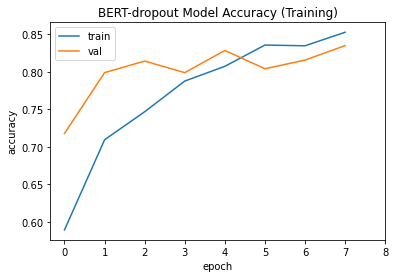

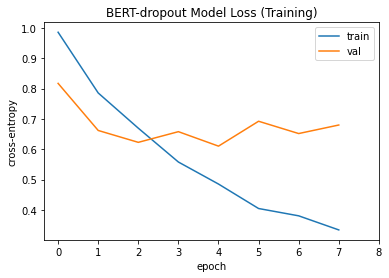

In [ ]:
plot_acc_loss_against_epoch(bert_model_dropout_history, max_range=9, title1='BERT-dropout Model Accuracy (Training)', title2='BERT-dropout Model Loss (Training)')

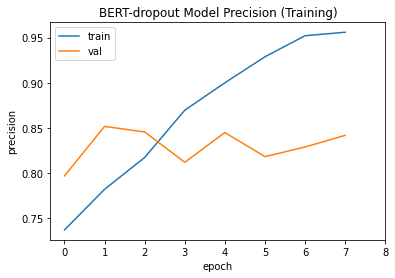

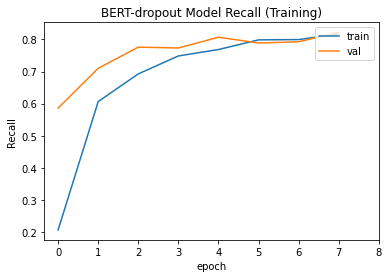

In [ ]:
plot_prec_recall_against_epoch(bert_model_dropout_history, max_range=9, title1='BERT-dropout Model Precision (Training)', title2='BERT-dropout Model Recall (Training)')

The addition of the dropout layer has reduced the overfitting of the model, but increased the number of epochs/ time until convergence.

### Effect of MAX_LEN on training

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def create_bert_inputs(df, max_len):
  """ 
  Creates bert features as in create_attention_masks(), 
  but with the addition of the parameter max_len to adjust the truncation/padding of sentences.
  """
  input_ids = []
  token_type_ids = []
  attention_masks = []
  for headline in df:
      tokenized_texts = tokenizer.encode_plus(" ".join(headline),
                                                  add_special_tokens=True,
                                                  max_length=max_len,
                                                  padding='max_length',
                                                  truncation=True,
                                                  return_attention_mask=True)
      input_ids.append(tokenized_texts['input_ids'])
      token_type_ids.append(tokenized_texts['token_type_ids'])
      attention_masks.append(tokenized_texts['attention_mask'])
  return input_ids, token_type_ids, attention_masks

In [18]:
def generate_custom_ds(batch_size, max_len):
  """
  Creates the train_ds and val_ds used for training with the updated max_len value.
  """
  hp_modified_train_input_ids, hp_modified_train_tokens, hp_modified_train_attention_masks = create_bert_inputs(fnews_Xtrain['News'], max_len)
  hp_modified_ttrain_input_ids, hp_modified_val_input_ids, hp_modified_ttrain_tokens, hp_modified_val_tokens, hp_modified_ttrain_attention_masks, hp_modified_val_attention_masks, hp_modified_ttrain_labels, hp_modified_val_labels = train_test_split(hp_modified_train_input_ids, hp_modified_train_tokens, hp_modified_train_attention_masks, train_labels, test_size=0.2)
  
  hp_modified_ttrain_inputs = tf.convert_to_tensor(hp_modified_ttrain_input_ids, dtype=tf.int32, name='input_ids')
  hp_modified_val_inputs = tf.convert_to_tensor(hp_modified_val_input_ids, dtype=tf.int32, name='input_ids')

  hp_modified_ttrain_tokens = tf.convert_to_tensor(hp_modified_ttrain_tokens,dtype=tf.int32, name='token_ids')
  hp_modified_val_tokens = tf.convert_to_tensor(hp_modified_val_tokens, dtype=tf.int32, name='token_ids')

  hp_modified_ttrain_masks = tf.convert_to_tensor(hp_modified_ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
  hp_modified_val_masks = tf.convert_to_tensor(hp_modified_val_attention_masks, dtype=tf.int32, name='attention_masks')

  hp_train_ds = tf.data.Dataset.from_tensor_slices((hp_modified_ttrain_inputs, hp_modified_ttrain_masks, hp_modified_ttrain_tokens, hp_modified_ttrain_labels)).map(map_to_dict).shuffle(len(hp_modified_ttrain_inputs)).batch(batch_size)
  hp_val_ds = tf.data.Dataset.from_tensor_slices((hp_modified_val_inputs, hp_modified_val_masks, hp_modified_val_tokens, hp_modified_val_labels)).map(map_to_dict).shuffle(len(hp_modified_val_inputs)).batch(batch_size)
  return hp_train_ds, hp_val_ds

In [19]:
def create_modified_max_length_model(max_len):
    """ Testing the effect of MAX_LEN on the model. """
    ids = keras.layers.Input(shape=((max_len,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((max_len,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((max_len,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dropout(0.2)(embedded_layer)
    outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

In [ ]:
max_lengths = [MAX_LEN//4, MAX_LEN//2]

epochs = 10
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
max_len_models = {}
max_len_model_histories = {}
max_len_model_te = {}
model_names = ['model1', 'model2']
for idx, max_len in enumerate(max_lengths):
  new_train_ds, new_val_ds = generate_custom_ds(8, max_len)
  max_len_models[model_names[idx]] = create_modified_max_length_model(max_len)
  max_len_models[model_names[idx]].compile(loss=loss,
                    optimizer=optimizer,
                    metrics=[metrics],
  )
  log_dir = "bert-dropout/fit/" + f'{max_len}/' + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

  max_len_model_te[model_names[idx]] = time_for_epoch()      
  max_len_model_histories[model_names[idx]] = max_len_models[model_names[idx]].fit(
      new_train_ds,
      epochs=epochs,
      validation_data=new_val_ds, 
      callbacks=[tensorboard_callback, max_len_model_te[model_names[idx]], es]
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 86)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 86)]         0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 86)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_8 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 172)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 172)]        0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, 172)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_9 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]',  

In [ ]:
# adding the old result to the model dictionaries
max_len_models['model3'] = bert_model_dropout
max_len_model_histories['model3'] = bert_model_dropout_history
max_len_model_te['model3'] = te_dropout

In [ ]:
# comparison of the results
# ranges = [3,4]
for idx, model in enumerate(model_names):
  print('RESULTS FOR ', model.upper())
  print_all_results(
      max_len_models[model],
      max_len_model_histories[model],
      max_len_model_te[model], 
      predict=False
  )
  print()
  # plot_acc_loss_againt_epoch(max_len_model_histories[model], max_range=ranges[idx], title1=f'BERT-{model} Model Accuracy (Training)', title2=f'BERT-{model} Model Loss (Training)')
  # plot_prec_recall_against_epoch(max_len_model_histories[model], max_range=ranges[idx], title1=f'BERT-{model} Model Precision (Training)', title2=f'BERT-{model} Model Recall (Training)')

RESULTS FOR  MODEL1
Train F1 Score of last epoch:  0.5117387983039308
Val F1 Score of last epoch:  0.5961038902144057
Time for each epoch:  99.2100350856781

RESULTS FOR  MODEL2
Train F1 Score of last epoch:  0.45029941433204146
Val F1 Score of last epoch:  0.04483187959659806
Time for each epoch:  152.1954799493154



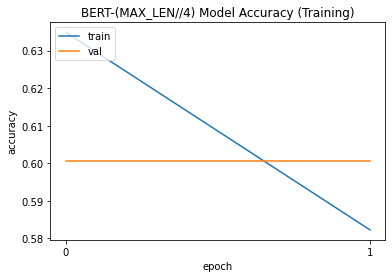

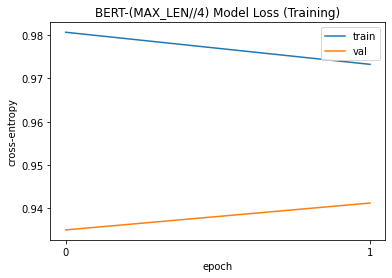

In [ ]:
plot_acc_loss_against_epoch(max_len_model_histories['model1'], 2, title1='BERT-(MAX_LEN//4) Model Accuracy (Training)', title2='BERT-(MAX_LEN//4) Model Loss (Training)')

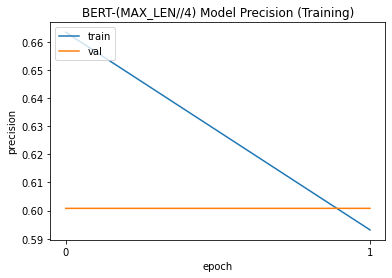

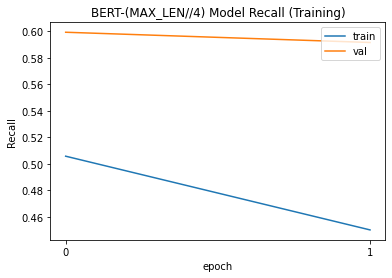

In [ ]:
plot_prec_recall_against_epoch(max_len_model_histories['model1'], max_range=2, title1='BERT-(MAX_LEN//4) Model Precision (Training)', title2='BERT-(MAX_LEN//4) Model Recall (Training)')

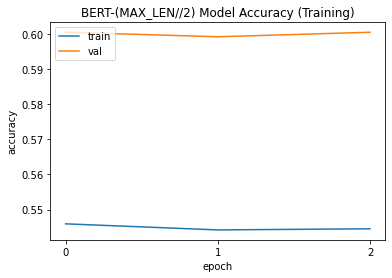

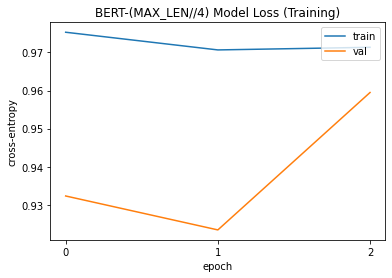

In [ ]:
plot_acc_loss_against_epoch(max_len_model_histories['model2'], 3, title1='BERT-(MAX_LEN//2) Model Accuracy (Training)', title2='BERT-(MAX_LEN//4) Model Loss (Training)')

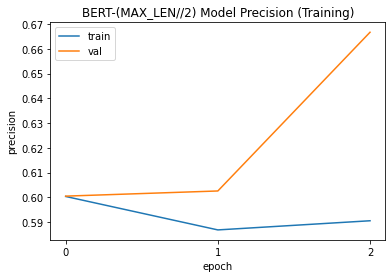

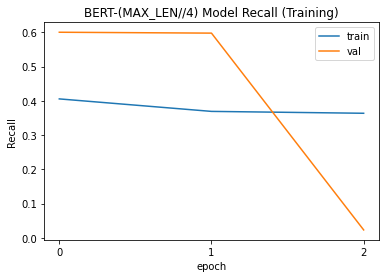

In [ ]:
plot_prec_recall_against_epoch(max_len_model_histories['model2'], max_range=3, title1='BERT-(MAX_LEN//2) Model Precision (Training)', title2='BERT-(MAX_LEN//4) Model Recall (Training)')

While reducing the max_length decreases the runtime, it worsens the model results quite significantly. Use original MAX_LEN defined.

### Effect of Learning Rate on BERT

In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 15.1 MB/s 
     |████████████████████████████████| 1.6 MB 57.1 MB/s 


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

# callbacks
checkpoint_callback = ModelCheckpoint('best_epoch', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
log_dir = "bert-tuning/fit/" + f'tuned-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def create_model_for_tuning(hp):
    hp_lr = hp.Choice('learning_rate', [5e-5, 3e-5, 2e-5, 1e-5]) # recommended lr for BERT
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model
 

In [ ]:
tuner = kt.Hyperband(create_model_for_tuning,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='',
                     overwrite=False,
                     project_name='hyperparam_tuning_for_BERT')


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# new_train_ds, new_val_ds = generate_custom_ds(32)
tuner.search(train_ds,
            epochs=10,
            validation_data=val_ds,
            callbacks=[es, checkpoint_callback, tensorboard_callback, te])

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 4 Complete [00h 12m 05s]
val_loss: 0.4668329358100891

Best val_loss So Far: 0.446364164352417
Total elapsed time: 00h 48m 54s


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# reloading the best trial
trials = tuner.oracle.trials
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
learning_rate: 3e-05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.446364164352417


In [ ]:
preds = best_model.evaluate(test_ds)
print('Updated LR Model - F1 Score on Test Data: ', f1_score(preds[2], preds[3]))

122/122 [==============================] - 29s 237ms/step - loss: 0.5073 - accuracy: 0.7979 - precision: 0.8063 - recall: 0.7856
Updated LR Model - F1 Score on Test Data:  0.7958224472539827


In [ ]:
# retraining the model on the full train & test dataset -- (not hyperparameter tuning)
from datetime import datetime
log_dir = "bert-newlr/fit/dropout" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

def create_updated_lr_model(dropout: bool=True):
    lr = 3e-5
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    if dropout:    
      outputs = keras.layers.Dropout(0.2)(embedded_layer)
      outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    else:
      outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

updated_lr_models = {}
updated_lr_model_histories = {}
names = ['with_dropout', 'without_dropout']
tes = {}
for name in names:
  tes[name] = time_for_epoch()   
  if name=='with_dropout':
    updated_lr_models[name] = create_updated_lr_model(True)
  else:
    updated_lr_models[name] = create_updated_lr_model(False)
  updated_lr_model_histories[name] = updated_lr_models[name].fit(train_ds,
                          epochs=5, # reduce number of epochs and es patience due to slower training
                          validation_data=val_ds, 
                          callbacks=[tensorboard_callback, tes[name], es]
                          )


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
485/485 [==============================] - 386s 739ms/step - loss: 0.7688 - accuracy: 0.7005 - precision: 0.7552 - recall: 0.5730 - val_loss: 0.5823 - val_accuracy: 0.7835 - val_precision: 0.8208 - val_recall: 0.7082
Epoch 2/5
485/485 [==============================] - 355s 731ms/step - loss: 0.5711 - accuracy: 0.7833 - precision: 0.8382 - recall: 0.7405 - val_loss: 0.5441 - val_accuracy: 0.8000 - val_precision: 0.8261 - val_recall: 0.7639
Epoch 3/5
485/485 [==============================] - 347s 715ms/step - loss: 0.4454 - accuracy: 0.8184 - precision: 0.8823 - recall: 0.7794 - val_loss: 0.6383 - val_accuracy: 0.8124 - val_precision: 0.8264 - val_recall: 0.7948


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
485/485 [==============================] - 370s 729ms/step - loss: 0.6410 - accuracy: 0.7530 - precision: 0.7816 - recall: 0.7097 - val_loss: 0.5409 - val_accuracy: 0.7557 - val_precision: 0.7630 - val_recall: 0.7402
Epoch 2/5
485/485 [==============================] - 348s 718ms/step - loss: 0.4069 - accuracy: 0.8462 - precision: 0.8530 - recall: 0.8385 - val_loss: 0.5043 - val_accuracy: 0.8010 - val_precision: 0.8090 - val_recall: 0.7948
Epoch 3/5
485/485 [==============================] - 348s 717ms/step - loss: 0.2616 - accuracy: 0.9027 - precision: 0.9078 - recall: 0.8994 - val_loss: 0.5531 - val_accuracy: 0.7979 - val_precision: 0.7988 - val_recall: 0.7979


Results for updated lr model  with_dropout
Train F1 Score of last epoch:  0.8276712435446928
Val F1 Score of last epoch:  0.8102995100558791
Time for each epoch:  362.14438915252686
122/122 [==============================] - 28s 231ms/step - loss: 0.5441 - accuracy: 0.8000 - precision: 0.8261 - recall: 0.7639
Test Prediction Results:  [0.5441184043884277, 0.800000011920929, 0.8260869383811951, 0.7639175057411194]
Test F1 Score:  0.7937868045920186

Results for updated lr model  without_dropout
Train F1 Score of last epoch:  0.9035769701514369
Val F1 Score of last epoch:  0.7983496748039318
Time for each epoch:  354.9170042673747
122/122 [==============================] - 29s 228ms/step - loss: 0.5043 - accuracy: 0.8010 - precision: 0.8090 - recall: 0.7948
Test Prediction Results:  [0.5042880177497864, 0.8010309338569641, 0.8090241551399231, 0.7948453426361084]
Test F1 Score:  0.8018720758574802



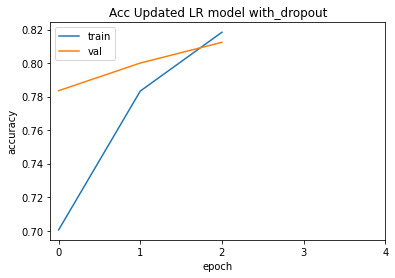

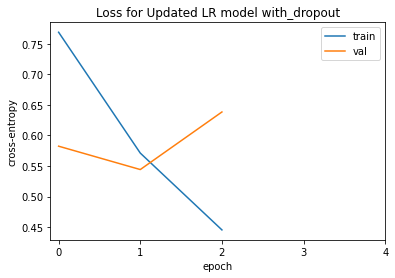

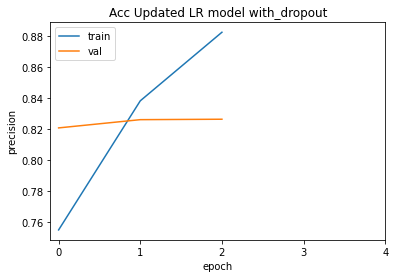

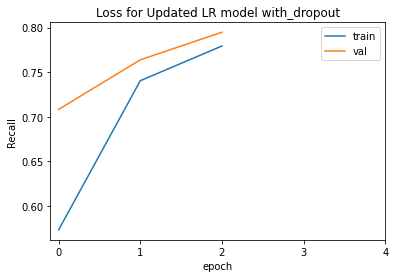

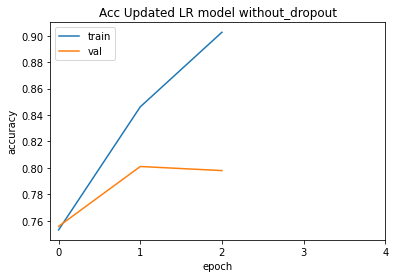

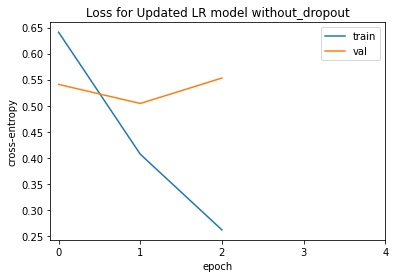

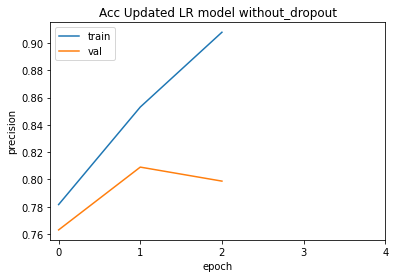

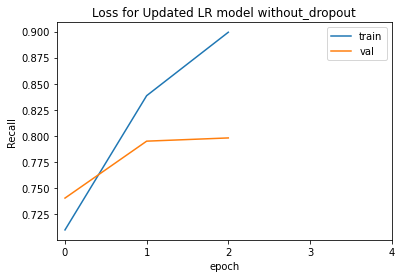

In [ ]:
for name in names:
  # note: titles for the precision and recall charts are incorrect here! Need to refer to the y-axis to see which metric is plotted.
  print('Results for updated lr model ', name)
  print_all_results(updated_lr_models[name], updated_lr_model_histories[name], tes[name])
  plot_acc_loss_against_epoch(updated_lr_model_histories[name], 5, title1='Acc Updated LR model '+name, title2='Loss for Updated LR model '+name)
  plot_prec_recall_against_epoch(updated_lr_model_histories[name], 5, title1='Acc Updated LR model '+name, title2='Loss for Updated LR model '+name)
  print()

Cannot see proper convergence because early stopping had patience=1, so the training was stopped very early. This could mean that the model is underfitting on the data in this training loop. However, due to computational constraints, it takes very long to run the training until convergence for such a small learning rate.

Dropout still does appear to be better at reducing the overfitting of the dataset, so the final model will use dropout.

In [ ]:
#  train until convergence on the dropout model
from datetime import datetime
log_dir = "bert-newlr/fit/dropout-final" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def create_updated_lr_model(dropout: bool=True):
    lr = 3e-5
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    if dropout:    
      outputs = keras.layers.Dropout(0.2)(embedded_layer)
      outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    else:
      outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

combined_train = train_ds.concatenate(val_ds)

te_final = time_for_epoch()   
final_lr_bert_model = create_updated_lr_model(True)
final_lr_bert_model_history = final_lr_bert_model.fit(combined_train,
                        epochs=10, # reduce number of epochs and es patience due to slower training
                        validation_data=test_ds, 
                        callbacks=[tensorboard_callback, te_final, es]
                        )


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
485/485 [==============================] - 395s 775ms/step - loss: 0.7415 - accuracy: 0.6445 - precision: 0.7381 - recall: 0.5591 - val_loss: 0.5072 - val_accuracy: 0.8031 - val_precision: 0.8387 - val_recall: 0.7557
Epoch 2/10
485/485 [==============================] - 348s 717ms/step - loss: 0.5330 - accuracy: 0.7358 - precision: 0.8240 - recall: 0.6860 - val_loss: 0.5226 - val_accuracy: 0.7938 - val_precision: 0.8059 - val_recall: 0.7835
Epoch 3/10
485/485 [==============================] - 347s 716ms/step - loss: 0.4278 - accuracy: 0.7743 - precision: 0.8524 - recall: 0.7345 - val_loss: 0.4921 - val_accuracy: 0.8052 - val_precision: 0.8185 - val_recall: 0.7948
Epoch 4/10
485/485 [==============================] - 345s 712ms/step - loss: 0.3485 - accuracy: 0.8021 - precision: 0.8796 - recall: 0.7637 - val_loss: 0.5670 - val_accuracy: 0.8144 - val_precision: 0.8265 - val_recall: 0.8052
Epoch 5/10
485/485 [==============================] - 346s 713ms/step - loss: 0.2946 - a

Fourth epoch seems to be the best epoch overall.

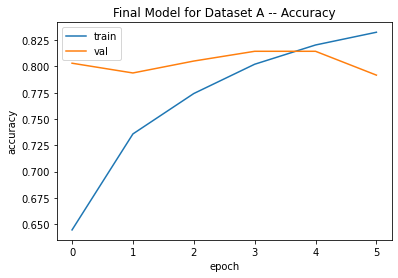

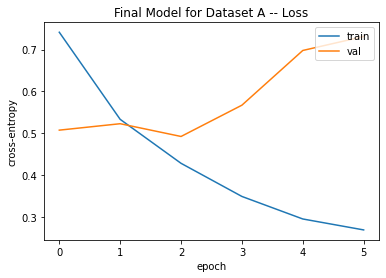

In [ ]:
plot_acc_loss_against_epoch(final_lr_bert_model_history, 6, title1='Updated LR Model for Dataset A -- Accuracy', title2='Updated LR Model for Dataset A -- Loss')

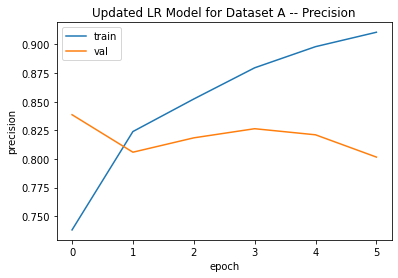

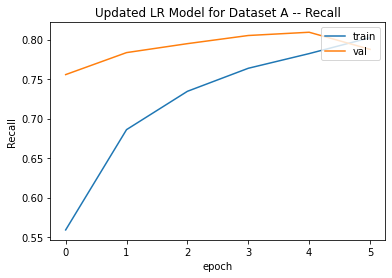

In [ ]:
plot_prec_recall_against_epoch(final_bert_model_history, 6, title1='Updated LR Model for Dataset A -- Precision', title2='Updated LR Model for Dataset A -- Recall')

### Adjusting Batch Size -- cannot go larger than 8, so we will try smaller batch sizes

In [ ]:
from datetime import datetime
log_dir = "bert-newbs/fit/dropout" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

def create_updated_bs_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    outputs = keras.layers.Dropout(0.2)(embedded_layer)
    outputs = keras.layers.Dense(3, activation='softmax')(outputs)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

updated_bs_models = {}
updated_bs_model_histories = {}
sizes = [2, 4]
bs_tes = {}
for bs in sizes:
  new_train_ds, new_val_ds = generate_custom_ds(bs, MAX_LEN)
  te = time_for_epoch()   
  updated_bs_models[bs] = create_updated_bs_model()
  updated_bs_model_histories[bs] = updated_bs_models[bs].fit(new_train_ds,
                          epochs=10,
                          batch_size=bs,
                          validation_data=new_val_ds, 
                          callbacks=[tensorboard_callback, te, es]
                          )
  bs_tes[bs] = te


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1550/1550 [==============================] - 370s 227ms/step - loss: 0.9729 - accuracy: 0.5966 - precision: 0.6782 - recall: 0.4614 - val_loss: 0.9409 - val_accuracy: 0.6005 - val_precision: 0.6005 - val_recall: 0.6005
Epoch 2/10
1550/1550 [==============================] - 345s 222ms/step - loss: 0.9849 - accuracy: 0.5410 - precision: 0.5837 - recall: 0.3961 - val_loss: 0.9534 - val_accuracy: 0.6005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1550/1550 [==============================] - 348s 224ms/step - loss: 0.9518 - accuracy: 0.5516 - precision: 0.6296 - recall: 0.4019 - val_loss: 0.9793 - val_accuracy: 0.6005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1550/1550 [==============================] - 344s 222ms/step - loss: 0.9642 - accuracy: 0.5568 - precision: 0.6090 - recall: 0.4306 - val_loss: 0.9363 - val_accuracy: 0.6005 - val_precision: 0.6005 - val_recall: 0.6005
Epoch 5/10
1550/1550 [==============================] - 344s 222

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
775/775 [==============================] - 337s 395ms/step - loss: 0.9911 - accuracy: 0.5390 - precision: 0.5927 - recall: 0.4265 - val_loss: 0.9454 - val_accuracy: 0.6005 - val_precision: 0.6009 - val_recall: 0.5064
Epoch 2/10
775/775 [==============================] - 312s 402ms/step - loss: 0.9923 - accuracy: 0.5297 - precision: 0.5884 - recall: 0.3394 - val_loss: 0.9506 - val_accuracy: 0.6005 - val_precision: 0.6005 - val_recall: 0.6005
Epoch 3/10
775/775 [==============================] - 302s 390ms/step - loss: 0.9858 - accuracy: 0.5416 - precision: 0.5811 - recall: 0.3848 - val_loss: 0.9561 - val_accuracy: 0.6005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
775/775 [==============================] - 299s 385ms/step - loss: 0.9739 - accuracy: 0.5519 - precision: 0.6004 - recall: 0.4400 - val_loss: 0.9429 - val_accuracy: 0.6005 - val_precision: 0.6005 - val_recall: 0.6005
Epoch 5/10
775/775 [==============================] - 300s 387ms/step - loss: 0.

KeyboardInterrupt: ignored

Stopped training early becuse it wasn't better than previous models and was much slower.

Results for updated bs model with batch_size= 2
Train F1 Score of last epoch:  0.5158027848085066
Val F1 Score of last epoch:  0.6005154848098755
Time for each epoch:  349.3844002485275
122/122 [==============================] - 26s 212ms/step - loss: 0.9182 - accuracy: 0.5918 - precision: 0.5918 - recall: 0.5918
Test Prediction Results:  [0.9181711077690125, 0.5917525887489319, 0.5917525887489319, 0.5917525887489319]
Test F1 Score:  0.5917525887489319

Results for updated bs model with batch_size= 4


KeyError: ignored

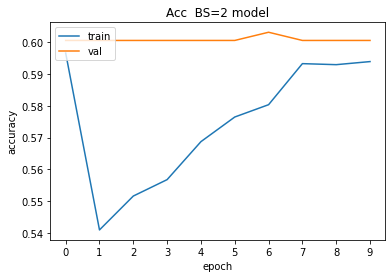

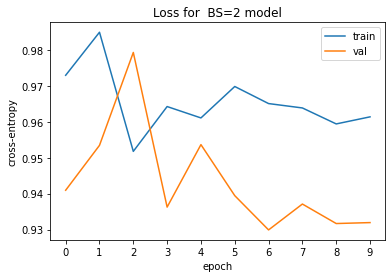

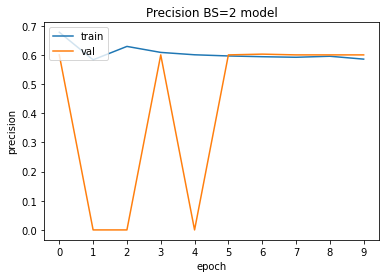

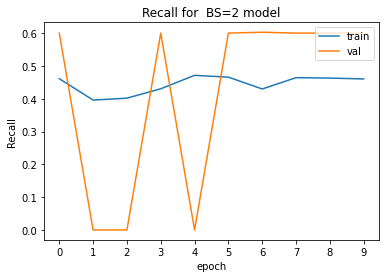

In [ ]:
for bs in sizes:
  print('Results for updated bs model with batch_size=', bs)
  print_all_results(updated_bs_models[bs], updated_bs_model_histories[bs], bs_tes[bs])
  plot_acc_loss_against_epoch(updated_bs_model_histories[bs], 10, title1=f'Acc  BS={bs} model', title2=f'Loss for  BS={bs} model')
  plot_prec_recall_against_epoch(updated_bs_model_histories[bs], 10, title1=f'Precision BS={bs} model', title2=f'Recall for  BS={bs} model')
  print()

### Using Back-Translation to augment the data and increase the sample size for under-represented classes

In [5]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
eng_to_de_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-de')
de_to_eng_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-de-en')
eng_to_de_tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-de')
de_to_eng_tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-de-en')

def translate(formatted_text, tokenizer, model, lang="de"):
  translations = model.generate(**tokenizer(formatted_text, return_tensors="pt",  max_length=MAX_LEN, padding='max_length', truncation=True))
  translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translations]
  return translated_texts

def back_translate(texts, tokenizer, origin_lang="en", temp_lang="de"):
  formatted_text =  [f'>>{temp_lang}<< {text}' for text in texts]
  temp_translated_text = translate(formatted_text, tokenizer, eng_to_de_model, temp_lang)
  back_translated_text = translate(temp_translated_text, tokenizer, de_to_eng_model, origin_lang)
  return back_translated_text

In [ ]:
# upsample the train dataset here
from sklearn.utils import resample
temp_full_df = fnews_Xtrain.copy()
temp_full_df['class'] = fnews_ytrain['Class']
neg_samples = temp_full_df[temp_full_df['class']=='negative']['News']
neu_samples = temp_full_df[temp_full_df['class']=='neutral']['News']
pos_samples = temp_full_df[temp_full_df['class']=='positive']['News']

# upsample negative and positive samples to neutral samples
neg_upsample = resample(neg_samples, replace=True, n_samples=len(neu_samples), random_state=42)
neg_upsample = set([back_translate(' '.join(x), eng_to_de_tokenizer) for x in neg_upsample])

pos_upsample = resample(pos_samples, replace=True, n_samples=len(neu_samples), random_state=42)
pos_upsample = set([back_translate(' '.join(x), eng_to_de_tokenizer) for x in pos_upsample])

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Unfortunately, BackTranslation uses too much RAM and keeps crashing the kernel.

# BERT For Dataset B: Squid Games Dataset

In [20]:
sg_Xtrain = pd.read_csv('squidgame_Xtrain.csv', index_col=0)   
sg_Xtest = pd.read_csv('squidgame_Xtest.csv', index_col=0) 
sg_ytrain = pd.read_csv('squidgame_ytrain.csv', index_col=0) 
sg_ytest = pd.read_csv('squidgame_ytest.csv', index_col=0) 

SG_MAX_LEN = max([len(x) for x in sg_Xtrain["Review"]]) if max([len(x) for x in sg_Xtrain["Review"]])<512 else MAX_LEN # resource allocation fails on larger max_len

# mapping the classes to a numeric representation
sg_train_labels = sg_ytrain['Class'].map({'neutral':1, 'positive': 2, 'negative': 0})
sg_test_labels = sg_ytest['Class'].map({'neutral':1, 'positive': 2, 'negative': 0})

full_X_data = pd.concat([sg_Xtrain, sg_Xtest], ignore_index=True)
full_y_data = pd.concat([sg_train_labels, sg_test_labels], ignore_index=True).values

sg_test_labels = sg_test_labels.values

# creating bert features
sg_train_input_ids, sg_train_tokens, sg_train_attention_masks = create_bert_inputs(sg_Xtrain['Review'], SG_MAX_LEN)
sg_test_input_ids, sg_test_tokens, sg_test_attention_masks = create_bert_inputs(sg_Xtest['Review'], SG_MAX_LEN)
sg_ttrain_input_ids, sg_val_input_ids, sg_ttrain_tokens, sg_val_tokens, sg_ttrain_attention_masks, sg_val_attention_masks, sg_ttrain_labels, sg_val_labels  = train_test_split(sg_train_input_ids, sg_train_tokens, sg_train_attention_masks, sg_train_labels.values, test_size=0.2)
print('Train shape: ', len(sg_ttrain_input_ids), len(sg_ttrain_tokens), len(sg_ttrain_attention_masks), len(sg_ttrain_labels))
print('Val shape: ', len(sg_val_input_ids), len(sg_val_tokens), len(sg_val_attention_masks), len(sg_val_labels))
print('Test shape: ', len(sg_test_input_ids), len(sg_test_tokens), len(sg_test_attention_masks), len(sg_test_labels))

Train shape:  758 758 758 758
Val shape:  190 190 190 190
Test shape:  237 237 237 237


In [21]:
sg_ttrain_inputs = tf.convert_to_tensor(sg_ttrain_input_ids, dtype=tf.int32, name='input_ids')
sg_val_inputs = tf.convert_to_tensor(sg_val_input_ids, dtype=tf.int32, name='input_ids')
sg_test_inputs = tf.convert_to_tensor(sg_test_input_ids, dtype=tf.int32, name='input_ids')

sg_ttrain_tokens = tf.convert_to_tensor(sg_ttrain_tokens,dtype=tf.int32, name='token_ids')
sg_val_tokens = tf.convert_to_tensor(sg_val_tokens, dtype=tf.int32, name='token_ids')
sg_test_tokens = tf.convert_to_tensor(sg_test_tokens, dtype=tf.int32, name='token_ids')

sg_ttrain_masks = tf.convert_to_tensor(sg_ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
sg_val_masks = tf.convert_to_tensor(sg_val_attention_masks, dtype=tf.int32, name='attention_masks')
sg_test_masks = tf.convert_to_tensor(sg_test_attention_masks, dtype=tf.int32, name='attention_masks')

# ttrain_labels = tf.convert_to_tensor(ttrain_labels)
# val_labels = tf.convert_to_tensor(val_labels)
# test_labels = tf.convert_to_tensor(test_labels)

sg_ttrain_labels = tf.keras.utils.to_categorical(sg_ttrain_labels, num_classes=NUM_CLASSES)
sg_val_labels = tf.keras.utils.to_categorical(sg_val_labels, num_classes=NUM_CLASSES)
sg_test_labels = tf.keras.utils.to_categorical(sg_test_labels, num_classes=NUM_CLASSES)

# reduce the batch size since the training sample is smaller, want to train the model slower so it can coverge to a minima better
BATCH_SIZE = 8
sg_train_ds = tf.data.Dataset.from_tensor_slices((sg_ttrain_inputs, sg_ttrain_masks, sg_ttrain_tokens, sg_ttrain_labels)).map(map_to_dict).shuffle(len(sg_ttrain_inputs)).batch(BATCH_SIZE)
sg_val_ds = tf.data.Dataset.from_tensor_slices((sg_val_inputs, sg_val_masks, sg_val_tokens, sg_val_labels)).map(map_to_dict).shuffle(len(sg_val_inputs)).batch(BATCH_SIZE)
sg_test_ds = tf.data.Dataset.from_tensor_slices((sg_test_inputs, sg_test_masks, sg_test_tokens, sg_test_labels)).map(map_to_dict).shuffle(len(sg_test_inputs)).batch(BATCH_SIZE)

 
# creating sq full ds for testing of Financial News Datasets on a different domain
full_X_data_ids, full_X_data_tokens, full_X_data_masks = create_bert_inputs(full_X_data['Review'], SG_MAX_LEN)
full_X_data_ids = tf.convert_to_tensor(full_X_data_ids, dtype=tf.int32, name='input_ids')
full_X_data_tokens = tf.convert_to_tensor(full_X_data_tokens, dtype=tf.int32, name='token_ids')
full_X_data_masks = tf.convert_to_tensor(full_X_data_masks, dtype=tf.int32, name='attention_masks')
full_y_data = tf.keras.utils.to_categorical(full_y_data, num_classes=NUM_CLASSES)
sg_full_ds = tf.data.Dataset.from_tensor_slices((full_X_data_ids, full_X_data_masks, full_X_data_tokens, full_y_data)).map(map_to_dict).shuffle(len(full_X_data_ids)).batch(BATCH_SIZE)

In [ ]:
# bert_model_dropout.evaluate(sg_full_ds)

149/149 [==============================] - 32s 213ms/step - loss: 3.1122 - accuracy: 0.0532 - precision: 0.0532 - recall: 0.0532


[3.1122281551361084,
 0.05316455662250519,
 0.05316455662250519,
 0.05316455662250519]

## Comparing the best performing parameters for the Financial News Dataset

In [ ]:
# simple finetuning for this dataset 
# i'll compare the use of drop vs non-dropout for this dataset
#  train until convergence on the dropout model
from datetime import datetime
log_dir = "bert-squidGames/fit/dropout" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def create_squid_games_model(dropout: bool=True):
    lr = 3e-5
    ids = keras.layers.Input(shape=((SG_MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((SG_MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((SG_MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    if dropout:    
      outputs = keras.layers.Dropout(0.2)(embedded_layer)
      outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    else:
      outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

sg_te = time_for_epoch()   
sg_model1 = create_squid_games_model(True)
sg_model1_history = sg_model1.fit(sg_train_ds,
                        epochs=10, # reduce number of epochs and es patience due to slower training
                        validation_data=sg_val_ds, 
                        callbacks=[tensorboard_callback, sg_te, es]
                        )


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
95/95 [==============================] - 104s 898ms/step - loss: 0.7525 - accuracy: 0.7152 - precision: 0.7554 - recall: 0.4821 - val_loss: 0.6052 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105
Epoch 2/10
95/95 [==============================] - 81s 858ms/step - loss: 0.7402 - accuracy: 0.6662 - precision: 0.7309 - recall: 0.6201 - val_loss: 0.6131 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105
Epoch 3/10
95/95 [==============================] - 82s 862ms/step - loss: 0.7261 - accuracy: 0.6979 - precision: 0.7570 - recall: 0.6451 - val_loss: 0.6467 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105


In [ ]:
print_all_results(sg_model1, sg_model1_history, sg_te)

Train F1 Score of last epoch:  0.6965811810175921
Val F1 Score of last epoch:  0.8105263113975525
Time for each epoch:  88.60723400115967
122/122 [==============================] - 27s 222ms/step - loss: 1.6792 - accuracy: 0.2979 - precision: 0.2979 - recall: 0.2979
Test Prediction Results:  [1.679193139076233, 0.29793813824653625, 0.29793813824653625, 0.29793813824653625]
Test F1 Score:  0.29793813824653625


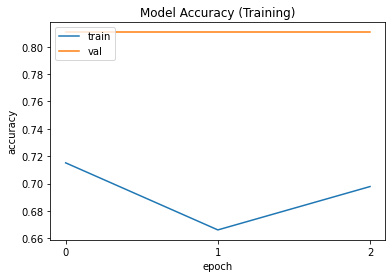

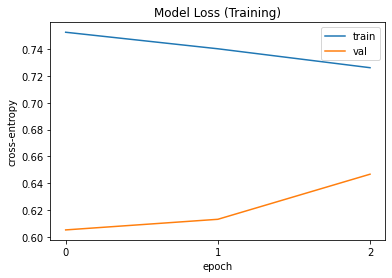

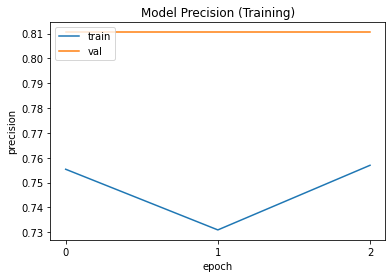

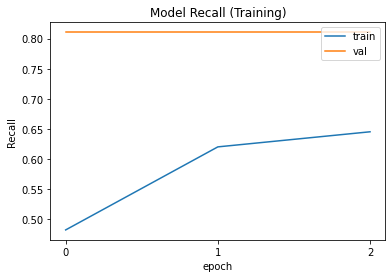

In [ ]:
plot_acc_loss_against_epoch(sg_model1_history, 3)
plot_prec_recall_against_epoch(sg_model1_history, 3)

In [ ]:
sg_te2 = time_for_epoch()   
sg_model2 = create_squid_games_model(False)
sg_model2_history = sg_model2.fit(sg_train_ds,
                        epochs=10,
                        validation_data=sg_val_ds, 
                        callbacks=[tensorboard_callback, sg_te2, es]
                        )


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
95/95 [==============================] - 110s 927ms/step - loss: 0.6850 - accuracy: 0.7757 - precision: 0.7962 - recall: 0.7269 - val_loss: 0.6337 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105
Epoch 2/10
95/95 [==============================] - 83s 873ms/step - loss: 0.6497 - accuracy: 0.7889 - precision: 0.7889 - recall: 0.7889 - val_loss: 0.6021 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105
Epoch 3/10
95/95 [==============================] - 83s 875ms/step - loss: 0.6489 - accuracy: 0.7889 - precision: 0.7889 - recall: 0.7889 - val_loss: 0.6060 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105


Train F1 Score of last epoch:  0.7889181971549988
Val F1 Score of last epoch:  0.8105263113975525
Time for each epoch:  91.72179714838664
122/122 [==============================] - 26s 212ms/step - loss: 1.5717 - accuracy: 0.2979 - precision: 0.2982 - recall: 0.2979
Test Prediction Results:  [1.5716508626937866, 0.29793813824653625, 0.2982456088066101, 0.29793813824653625]
Test F1 Score:  0.29809179424049254


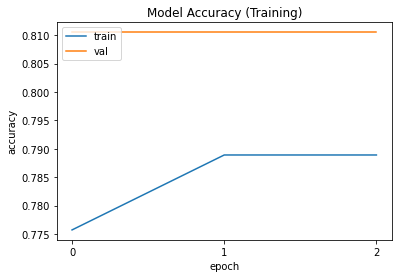

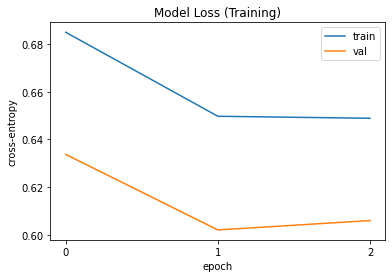

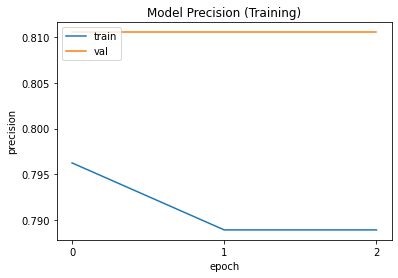

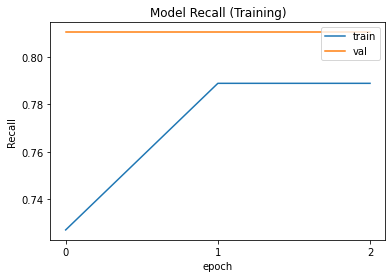

In [ ]:
print_all_results(sg_model2, sg_model2_history, sg_te2)
plot_acc_loss_against_epoch(sg_model2_history, 3)
plot_prec_recall_against_epoch(sg_model2_history, 3)

In [ ]:
print_all_results(sg_model1, sg_model1_history, sg_te)

Train F1 Score of last epoch:  0.6965811810175921
Val F1 Score of last epoch:  0.8105263113975525
Time for each epoch:  88.60723400115967
122/122 [==============================] - 27s 222ms/step - loss: 1.6792 - accuracy: 0.2979 - precision: 0.2979 - recall: 0.2979
Test Prediction Results:  [1.679193139076233, 0.29793813824653625, 0.29793813824653625, 0.29793813824653625]
Test F1 Score:  0.29793813824653625


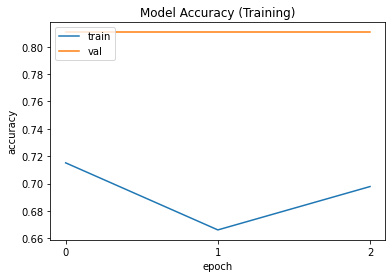

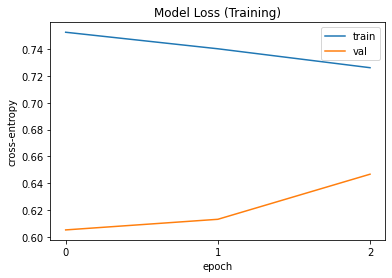

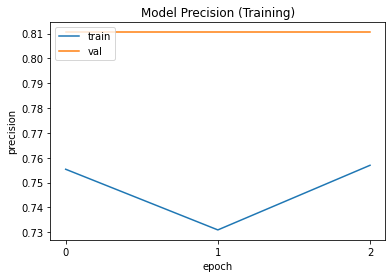

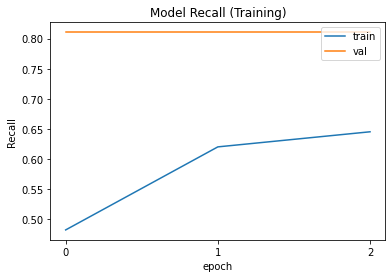

In [ ]:
plot_acc_loss_against_epoch(sg_model1_history, 3)
plot_prec_recall_against_epoch(sg_model1_history, 3)

In [ ]:
# Testing with a higher learning rate (one of the better models for Dataset A)
# simple finetuning for this dataset 
# i'll compare the use of drop vs non-dropout for this dataset
#  train until convergence on the dropout model
from datetime import datetime
log_dir = "bert-squidGames/fit/dropout_changelr" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def create_squid_games_model(dropout: bool=True):
    lr = 1e-5
    ids = keras.layers.Input(shape=((SG_MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((SG_MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((SG_MAX_LEN,)), name="attention_masks", dtype="int32") 

    inputs = [ids, tokens, masks]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    if dropout:    
      outputs = keras.layers.Dropout(0.1)(embedded_layer)
      outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    else:
      outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

sg_te3 = time_for_epoch()   
sg_model3 = create_squid_games_model(True)
sg_model3_history = sg_model3.fit(sg_train_ds,
                        epochs=10, # reduce number of epochs and es patience due to slower training
                        validation_data=sg_val_ds, 
                        callbacks=[tensorboard_callback, sg_te3, es]
                        )


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
95/95 [==============================] - 118s 1s/step - loss: 0.7804 - accuracy: 0.7836 - precision: 0.7858 - recall: 0.6438 - val_loss: 0.6618 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 2/10
95/95 [==============================] - 96s 1s/step - loss: 0.7066 - accuracy: 0.7916 - precision: 0.7853 - recall: 0.7045 - val_loss: 0.6495 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/10
95/95 [==============================] - 94s 994ms/step - loss: 0.6796 - accuracy: 0.7916 - precision: 0.7959 - recall: 0.7203 - val_loss: 0.6307 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/10
95/95 [==============================] - 92s 968ms/step - loss: 0.6984 - accuracy: 0.7810 - precision: 0.7934 - recall: 0.6992 - val_loss: 0.6335 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5/10
95/95 [==============================] - 92s 976ms/step - loss: 0.6870 - accuracy: 0.7797 - pr

Train F1 Score of last epoch:  0.7508674514333563
Val F1 Score of last epoch:  0.800000011920929
Time for each epoch:  98.1619607925415
122/122 [==============================] - 31s 252ms/step - loss: 1.2413 - accuracy: 0.2979 - precision: 0.2979 - recall: 0.2979
Test Prediction Results:  [1.241344928741455, 0.29793813824653625, 0.29793813824653625, 0.29793813824653625]
Test F1 Score:  0.29793813824653625


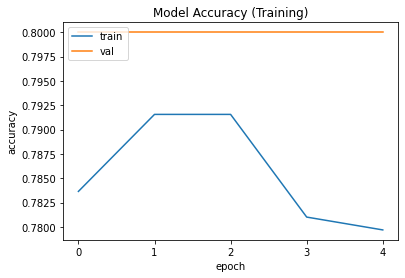

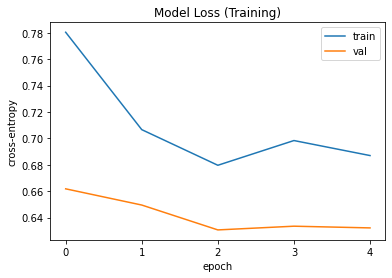

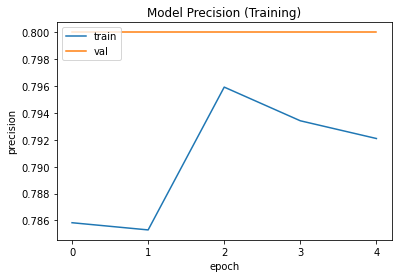

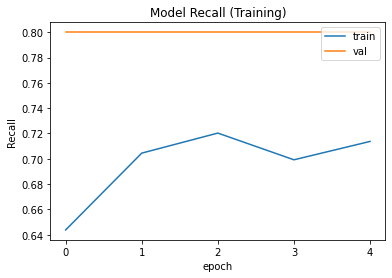

In [ ]:
print_all_results(sg_model3, sg_model3_history, sg_te3)
plot_acc_loss_against_epoch(sg_model3_history, 5)
plot_prec_recall_against_epoch(sg_model3_history, 5)

In [ ]:
np.unique(np.argmax(sg_val_labels, axis=1), return_counts=True)

(array([0, 1, 2]), array([ 30,   8, 152]))

Notice how the val_acc, val_prec and val_recall are the same for both models. I believe this is because of the uneven class distribution. I will upsample the underrepresented classes for this model and augment them.

You can see from the validation dataset, the other 2 classes are unrepresented.

In [ ]:
print('accuracy if you predict all classes as positive:', 152/np.sum([30,8,152]))

accuracy if you predict all classes as positive: 0.8


This is precisely the value we received in the last model. The uneven class distribution is causing the model to just predict every sample as positive.

## Applying Data Augmentation and Upsampling to balance out the uneven classes

In [22]:
# i'll apply data augmentation to this dataset

from sklearn.utils import resample
temp_full_df = sg_Xtrain.copy()
temp_full_df['class'] = sg_ytrain['Class']
neg_samples = temp_full_df[temp_full_df['class']=='negative']['Review'].values
neu_samples = temp_full_df[temp_full_df['class']=='neutral']['Review'].values
pos_samples = temp_full_df[temp_full_df['class']=='positive']['Review'].values
neg_upsample = resample(neg_samples, replace=True, n_samples=len(pos_samples), random_state=42)
neu_upsample = resample(neu_samples, replace=True, n_samples=len(pos_samples), random_state=42)

In [23]:
len(pos_samples)

752

In [24]:
sg_new_X_train = np.concatenate([pos_samples,neg_upsample,neu_upsample])
sg_new_X_train.shape

(2256,)

In [127]:
sg_new_y_train = np.concatenate([np.repeat(np.array(2),len(pos_samples)),np.repeat(np.array(0),len(pos_samples)),np.repeat(np.array(1),len(pos_samples))])

In [128]:
sg_new_y_train.shape

(2256,)

In [129]:
# apply data augmentation to a random sample of the train
# split into train and val, and augment the train data
sg_new_ttrain, sg_new_val, sg_new_ttrain_labels, sg_new_val_labels = train_test_split(sg_new_X_train, sg_new_y_train, test_size=0.2)

In [28]:
np.unique(sg_new_val_labels, return_counts=True)

(array([0, 1, 2]), array([149, 154, 149]))

Much better class distribution after upsampling.

### Applying GENSIM word2vec for augmentation

In [29]:
from gensim.models import Word2Vec
import gensim.downloader as api
model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
word_vectors = model.wv #load the vectors from the model

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [48]:
sg_new_ttrain = pd.Series(sg_new_ttrain).apply(eval)
sg_new_val = pd.Series(sg_new_val).apply(eval)

In [55]:
# creating more input features by converting the words in the headlines to vectors
# then applying tsne to reduce the dimensionality
vector_list = []
words_filtered = []
for row in sg_new_ttrain.to_list():
  vector_list+=[word_vectors[word] for word in row if word in word_vectors.vocab]
  words_filtered+=[word for word in row if word in word_vectors.vocab]
word_vec_zip = zip(words_filtered, vector_list)
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
This,-0.289062,0.199219,0.160156,0.025269,-0.236328,0.102051,0.066406,-0.165039,0.125977,0.220703,...,-0.226562,-0.024780,-0.133789,0.049072,-0.132812,-0.275391,0.004639,0.127930,0.121094,-0.229492
good,0.040527,0.062500,-0.017456,0.078613,0.032715,-0.012634,0.009644,0.123535,-0.021484,0.152344,...,0.014221,0.187500,-0.165039,0.015381,-0.041748,0.054443,-0.011841,-0.156250,0.001930,-0.069824
interesting,0.115723,-0.135742,-0.087891,0.144531,0.084961,-0.037598,0.196289,0.198242,0.017212,0.155273,...,0.063477,-0.091309,0.062988,0.040039,0.014038,-0.076172,0.183594,-0.082031,-0.156250,0.032959


In [61]:
df.shape

(5856, 300)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity = 100)

tsne_df = tsne.fit_transform(df)
tsne_df.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


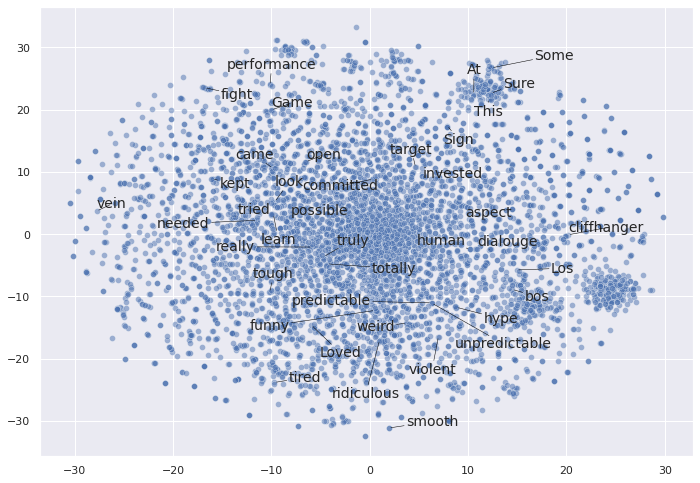

In [60]:
sns.set()
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [76]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=1, init='random', random_state=42, perplexity = 100)
tsne_df = tsne.fit_transform(df)
tsne_df = pd.DataFrame(tsne_df)
tsne_df.index = df.index
# map word to vector
mapper = tsne_df.to_dict('index')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [120]:
sg_new_train_input_ids, sg_new_train_tokens, sg_new_train_attention_masks = create_attention_masks(sg_new_ttrain)
sg_new_val_input_ids, sg_new_val_tokens, sg_new_val_attention_masks = create_attention_masks(sg_new_val)
print('Train shape: ', len(sg_new_train_input_ids), len(sg_new_train_tokens), len(sg_new_train_attention_masks), len(sg_new_ttrain_labels))
print('Val shape: ', len(sg_new_val_input_ids), len(sg_new_val_tokens), len(sg_new_val_attention_masks), len(sg_new_val_labels))

Train shape:  1804 1804 1804 1804
Val shape:  452 452 452 452


In [80]:
len(sg_new_train_input_ids[0])

345

In [110]:
# add an additional layer of vectorised words for each layer
vectorised_inputs = []
for row in sg_new_ttrain.to_list():
  temp = [mapper[word][0] for word in row if word in mapper.keys()]
  padding = 345 - len(temp)
  if padding > 0:
    temp = np.pad(temp, (0, padding), 'constant')
  if padding < 0 :
    temp = temp[:345]
  vectorised_inputs.append(temp)

In [111]:
# add an additional layer of vectorised words for each layer
vectorised_inputs_val = []
for row in sg_new_val.to_list():
  temp = [mapper[word][0] for word in row if word in mapper.keys()]
  padding = 345 - len(temp)
  if padding > 0:
    temp = np.pad(temp, (0, padding), 'constant')
  if padding < 0 :
    temp = temp[:345]
  vectorised_inputs_val.append(temp)

In [130]:
NUM_CLASSES = 3
sg_new_train_input_ids = tf.convert_to_tensor(sg_new_train_input_ids, dtype=tf.int32, name='input_ids')
sg_new_val_input_ids = tf.convert_to_tensor(sg_new_val_input_ids, dtype=tf.int32, name='input_ids')

sg_new_train_tokens = tf.convert_to_tensor(sg_new_train_tokens,dtype=tf.int32, name='token_ids')
sg_new_val_tokens = tf.convert_to_tensor(sg_new_val_tokens, dtype=tf.int32, name='token_ids')

sg_new_train_attention_masks = tf.convert_to_tensor(sg_new_train_attention_masks, dtype=tf.int32, name='attention_masks')
sg_new_val_attention_masks = tf.convert_to_tensor(sg_new_val_attention_masks, dtype=tf.int32, name='attention_masks')

ttrain_vectors = tf.convert_to_tensor(np.stack(vectorised_inputs), dtype=tf.float64, name='vectorised_inputs')
val_vectors = tf.convert_to_tensor(np.stack(vectorised_inputs_val), dtype=tf.float64, name='vectorised_inputs')

# ttrain_labels = tf.convert_to_tensor(ttrain_labels)
# val_labels = tf.convert_to_tensor(val_labels)
# test_labels = tf.convert_to_tensor(test_labels)

sg_new_ttrain_labels = tf.keras.utils.to_categorical(sg_new_ttrain_labels, num_classes=NUM_CLASSES)
sg_new_val_labels = tf.keras.utils.to_categorical(sg_new_val_labels, num_classes=NUM_CLASSES)


def map_to_dict(inputs, masks, tokens, vectors, labels):
    return {
        'input_ids': inputs,
        'attention_masks': masks,
        'token_ids': tokens,
        'vectorised_inputs': vectors,
    }, labels

BATCH_SIZE = 8 # larger batch sizes would crash our kernel
train_ds = tf.data.Dataset.from_tensor_slices((sg_new_train_input_ids, sg_new_train_tokens, sg_new_train_attention_masks, ttrain_vectors, sg_new_ttrain_labels)).map(map_to_dict).shuffle(len(sg_new_train_tokens)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((sg_new_val_input_ids, sg_new_val_tokens, sg_new_val_attention_masks, val_vectors, sg_new_val_labels)).map(map_to_dict).shuffle(len(sg_new_val_tokens)).batch(BATCH_SIZE)

In [ ]:
# Testing with a higher learning rate (one of the better models for Dataset A)
# simple finetuning for this dataset 
# i'll compare the use of drop vs non-dropout for this dataset
#  train until convergence on the dropout model
from datetime import datetime
log_dir = "bert-squidGames/fit/dropout_changelr" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def create_squid_games_final_model(dropout: bool=True):
    lr = 1e-5
    ids = keras.layers.Input(shape=((SG_MAX_LEN,)), name="input_ids", dtype="int32")
    tokens = keras.layers.Input(shape=((SG_MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((SG_MAX_LEN,)), name="attention_masks", dtype="int32") 
    vectors = keras.layers.Input(shape=((SG_MAX_LEN,)), name="vectorised_inputs", dtype="int32") 

    inputs = [ids, tokens, masks, vectors]
    config = BertConfig()
    config.output_hidden_states = False

    bert_model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks, token_type_ids=tokens)[0]
    if dropout:    
      outputs = keras.layers.Dropout(0.1)(embedded_layer)
      outputs = keras.layers.Dense(3, activation='softmax')(outputs)
    else:
      outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)

    model = keras.Model(inputs, outputs)  
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics],
    )
    return model

sg_te4 = time_for_epoch()   
sg_model4 = create_squid_games_final_model(True)
sg_model4_history = sg_model4.fit(train_ds,
                        epochs=5, 
                        validation_data=val_ds, 
                        callbacks=[tensorboard_callback, sg_te4, es]
                        )


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
226/226 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.3343 - precision: 0.5200 - recall: 0.0072

Session keeps crashing due to lack of RAM. 